## RGS14 Sleep state transition research based on aperiodic signal 
### Part 1: Process data

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as io
import math

from collections import Counter
from scipy import signal, io
from scipy.ndimage import gaussian_filter
from fooof import FOOOF
import os

import pingouin as pg
from pingouin import pairwise_gameshowell

### 1.1 Load in all data
- Data is stored locally 
- Folders for each condition HomeCageHC / OverlappingOR /...
- Each condition contains folder Rat1 till Rat9
- Each rat folder contains `HPC_100.continuous.mat`, `PFC_100.continuous.mat`, `states.mat`


In [ ]:


BASE_DATA_DIR = "./data"
CONDITIONS_DIR_NAMES = ['HomeCageHC', "OverlappingOR", "RandomCon", "StableCondOD"]
CONTROL_RATS = [1, 2, 6, 9]
RGS_RATS = [3, 4, 7, 8]

STATE_MAP = {
    1: 'Wake',
    3: 'NREM',
    4: 'Inter',
    5: 'REM'
}

# Initialize the data structure
rats_data = {
    condition: {
        'rgs_positive': [],
        'rgs_negative': []
    }
    for condition in CONDITIONS_DIR_NAMES
}

for condition in CONDITIONS_DIR_NAMES:
    for rat_index in CONTROL_RATS:
        folder_dir = f"{BASE_DATA_DIR}/{condition}/Rat{rat_index}/Post-Trial5"
        print(f'Loading Rat{rat_index} data condition {condition}, DIR: {folder_dir}')
        states_mat = io.loadmat(f'{folder_dir}/states.mat')
        hpc_mat = io.loadmat(f'{folder_dir}/HPC_cleaned.mat')
        pfc_mat = io.loadmat(f'{folder_dir}/PFC_cleaned.mat')

        data_object = {
            'number': rat_index,
            'states': states_mat['states'].ravel(),
            'hpc': hpc_mat['HPC_cleaned'].ravel(),
            'pfc': pfc_mat['PFC_cleaned'].ravel(),
        }
        rats_data[condition]['rgs_negative'].append(data_object)

    for rat_index in RGS_RATS:
        folder_dir = f"{BASE_DATA_DIR}/{condition}/Rat{rat_index}/Post-Trial5"
        print(f'Loading Rat{rat_index} data condition {condition}, DIR: {folder_dir}')
        states_mat = io.loadmat(f'{folder_dir}/states.mat')
        hpc_mat = io.loadmat(f'{folder_dir}/HPC_cleaned.mat')
        pfc_mat = io.loadmat(f'{folder_dir}/PFC_cleaned.mat')

        data_object = {
            'number': rat_index,
            'states': states_mat['states'].ravel(),
            'hpc': hpc_mat['HPC_cleaned'].ravel(),
            'pfc': pfc_mat['PFC_cleaned'].ravel(),
        }
        rats_data[condition]['rgs_positive'].append(data_object)

print(f'Successfully loaded cleaned data for conditions: {CONDITIONS_DIR_NAMES}')



Processing condition: HomeCageHC
Processing Rat1 (Control)
  Loading Trial 1 from: ./data/HomeCageHC/Rat1/2018-08-01_11-21-14_Post-Trial1
    Successfully loaded Trial 1 - States: 2700, HPC: 2700698, PFC: 2700698
  Loading Trial 2 from: ./data/HomeCageHC/Rat1/2018-08-01_12-11-44_Post-Trial2
    Successfully loaded Trial 2 - States: 2700, HPC: 2700664, PFC: 2700664
  Loading Trial 3 from: ./data/HomeCageHC/Rat1/2018-08-01_13-02-00_Post-Trial3
    Successfully loaded Trial 3 - States: 2700, HPC: 2700937, PFC: 2700937
  Loading Trial 4 from: ./data/HomeCageHC/Rat1/2018-08-01_13-53-50_Post-Trial4
    Successfully loaded Trial 4 - States: 2752, HPC: 2753298, PFC: 2753298
  Loading Trial 5 from: ./data/HomeCageHC/Rat1/Post-Trial5
    Successfully loaded Trial 5 - States: 10758, HPC: 10760978, PFC: 10760978
Processing Rat2 (Control)
  Loading Trial 1 from: ./data/HomeCageHC/Rat2/2018-07-30_12-15-16_Post-Trial1
    Successfully loaded Trial 1 - States: 2701, HPC: 2702268, PFC: 2702268
  Loadi

In [ ]:
# parameters from paper
sample_freq = 1000
adc_scale_uv = 0.195
window_sec = 15
noverlap = window_sec * sample_freq // 2
exponent_range = (1, 30)

def extract_foof_exponents(eeg):
    data = eeg.astype(np.float64) * adc_scale_uv
    nperseg = window_sec * sample_freq
    nfft = max(2048, 1 << (nperseg - 1).bit_length())
    f, t, Pxx = signal.spectrogram(
        data, sample_freq, window='hamming', nperseg=nperseg,
        noverlap=noverlap, nfft=nfft, detrend='constant',
        scaling='density', mode='psd'
    )
    times = t + window_sec / 2
    exponents = []

    for col in range(Pxx.shape[1]):
        fm = FOOOF(aperiodic_mode='fixed', verbose=False)
        try:
            fm.fit(f, Pxx[:, col], exponent_range)
            exponents.append(fm.aperiodic_params_[1])
        except Exception:
            exponents.append(np.nan)

    return times, np.array(exponents)

def save_rat_features(rat_data, group, condition, region, out_base_dir='./data/FoofExponents'):
    rat_id = rat_data['number']
    eeg = rat_data[region.lower()]  # 'hpc' or 'pfc'
    out_dir = os.path.join(out_base_dir, condition)
    os.makedirs(out_dir, exist_ok=True)
    out_file = os.path.join(out_dir, f"FOOF_Rat{rat_id}_{region}.npz")
    if os.path.exists(out_file):
        print(f"[SKIP] {out_file} already exists.")
        return
    times, exponents = extract_foof_exponents(eeg)
    np.savez(out_file, rat_id=rat_id, group=group, region=region,
             times=times, exponents=exponents)
    print(f"[✓] Saved FOOF bins for Rat {rat_id} ({group}, {condition}, {region}) to {out_file}")


for condition in CONDITIONS_DIR_NAMES:
    for group, group_key in [('RGS', 'rgs_positive'), ('Control', 'rgs_negative')]:
        for rat_data in rats_data[condition][group_key]:
            for region in ['HPC', 'PFC']:
                try:
                    save_rat_features(rat_data, group, condition, region)
                except Exception as e:
                    print(f"[X] Failed for Rat {rat_data['number']} ({group}, {condition}, {region}): {e}")

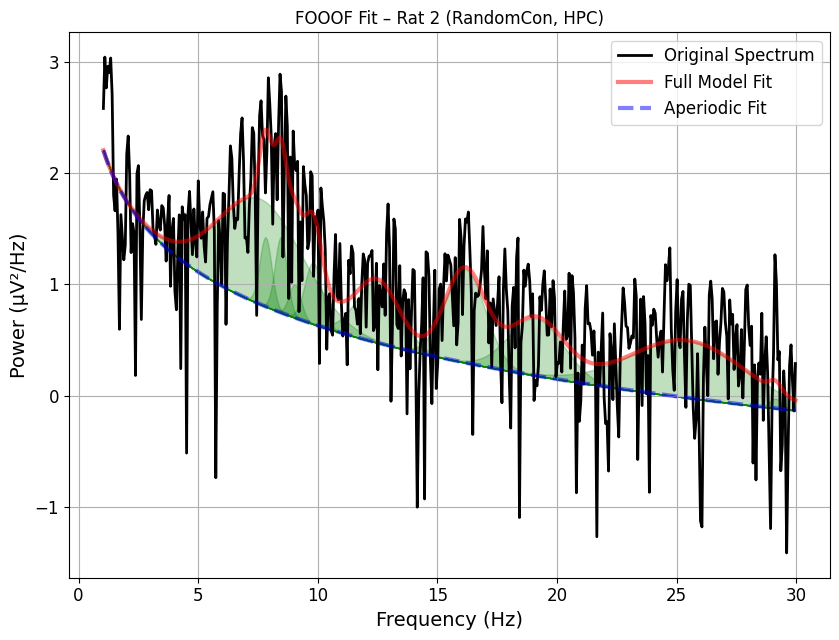

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from fooof import FOOOF


BASE_DATA_DIR = "./data"
CONDITIONS_DIR_NAMES = ['HomeCageHC', "OverlappingOR", "RandomCon", "StableCondOD"]
CONTROL_RATS = [1, 2, 6, 9]
RGS_RATS = [3, 4, 7, 8]
REGION = "HPC"  # or "PFC"
SAMPLE_FREQ = 1000
ADC_SCALE = 0.195
WINDOW_SEC = 15
FREQ_RANGE = (1, 30)


condition = "RandomCon"
rat_number = 2 
folder = f"{BASE_DATA_DIR}/{condition}/Rat{rat_number}/Post-Trial5"


hpc_data = io.loadmat(os.path.join(folder, "HPC_cleaned.mat"))["HPC_cleaned"].ravel()
eeg = hpc_data.astype(np.float64) * ADC_SCALE  # convert to µV


n_samples = SAMPLE_FREQ * WINDOW_SEC
start_idx = 50000  
eeg_segment = eeg[start_idx : start_idx + n_samples]

nfft = 1 << (n_samples - 1).bit_length()
f, Pxx = signal.welch(
    eeg_segment, fs=SAMPLE_FREQ, window='hamming',
    nperseg=n_samples, noverlap=n_samples // 2, nfft=nfft,
    scaling='density'
)


fm = FOOOF(aperiodic_mode='fixed', verbose=False)
fm.fit(f, Pxx, FREQ_RANGE)

# --- Plot ---
fm.plot(plot_peaks='shade', add_legend=True)
plt.title(f"FOOOF Fit – Rat {rat_number} ({condition}, {REGION})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (μV²/Hz)")
plt.tight_layout()
plt.show()


### 1.2 Analysing all state transition and frequency

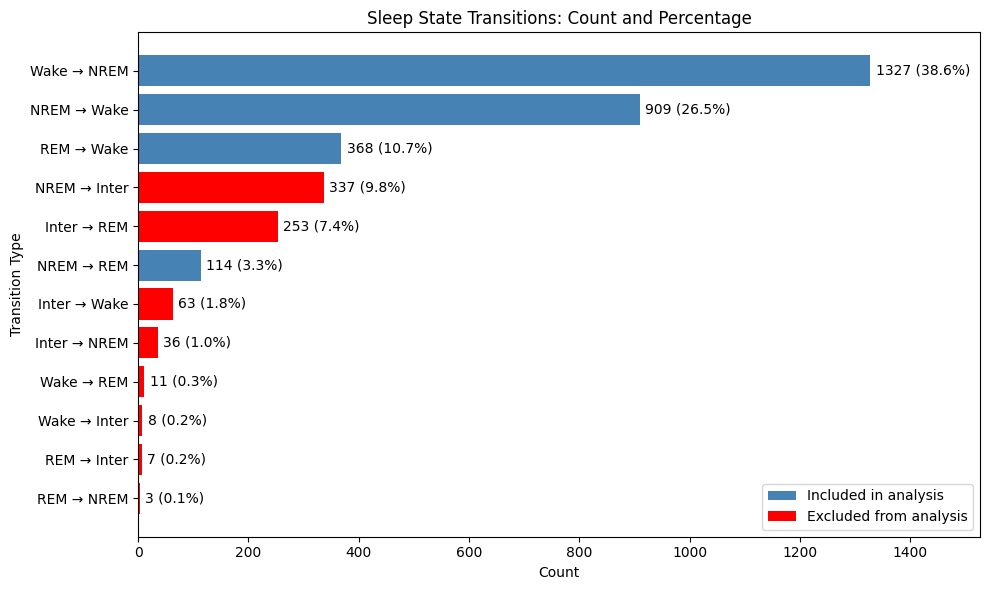

In [68]:
import matplotlib.pyplot as plt
from collections import Counter
import math

# Define transitions used in your analysis
USED_TRANSITIONS = {
    (1, 3),  # Wake → NREM
    (3, 5),  # NREM → REM
    (5, 1),  # REM → Wake
    (3, 1),  # NREM → Wake (added justification)
}

def is_unknown(state):
    return (state == 0) or (str(state).lower() == 'nan') or (isinstance(state, float) and math.isnan(state))

def transition_label(from_state, to_state):
    from_label = STATE_MAP.get(from_state, 'Unknown')
    to_label = STATE_MAP.get(to_state, 'Unknown')
    if is_unknown(from_state) or is_unknown(to_state) or from_label == 'Unknown' or to_label == 'Unknown':
        return 'Unknown ↔ Other'
    else:
        return f"{from_label} → {to_label}"

grouped_transitions = Counter()
global_transition_counts = Counter()

for condition in CONDITIONS_DIR_NAMES:
    for group in ['rgs_positive', 'rgs_negative']:
        for rat in rats_data[condition][group]:
            states = rat['states']
            for i in range(1, len(states)):
                from_state = states[i - 1]
                to_state = states[i]
                if from_state != to_state and not is_unknown(from_state) and not is_unknown(to_state):
                    global_transition_counts[(from_state, to_state)] += 1

# Group and label transitions
for (from_state, to_state), count in global_transition_counts.items():
    if from_state != to_state:
        label = transition_label(from_state, to_state)
        grouped_transitions[label] += count

sorted_transitions = sorted(grouped_transitions.items(), key=lambda x: x[1], reverse=True)
total_transitions = sum(count for _, count in sorted_transitions)

# Build color mapping
labels = [lbl for lbl, _ in sorted_transitions]
counts = [count for _, count in sorted_transitions]
percentages = [(count / total_transitions) * 100 for count in counts]

# Determine colors based on inclusion in USED_TRANSITIONS
color_map = []
for label in labels:
    # Reverse lookup to get the transition tuple for this label
    for (from_state, to_state) in global_transition_counts:
        if transition_label(from_state, to_state) == label:
            if (from_state, to_state) in USED_TRANSITIONS:
                color_map.append('steelblue')
            else:
                color_map.append('red')
            break

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(sorted_transitions)), counts, color=color_map)

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height() / 2,
             f'{counts[i]} ({percentages[i]:.1f}%)',
             va='center', ha='left')


plt.xlim(0, max(counts) * 1.15)
plt.yticks(range(len(sorted_transitions)), labels)
plt.gca().invert_yaxis()
plt.title('Sleep State Transitions: Count and Percentage')
plt.xlabel('Count')
plt.ylabel('Transition Type')

# Add color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Included in analysis'),
    Patch(facecolor='red', label='Excluded from analysis'),
  
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()


In [64]:
from statsmodels.stats.power import FTestAnovaPower

analysis = FTestAnovaPower()
required_n = analysis.solve_power(effect_size=0.25, k_groups=8, alpha=0.05, power=0.8)
print(f"Required sample size per transition: {required_n:.1f}")


Required sample size per transition: 236.7


### 1.2 Save FOOF exponents
- Calculating FOOF exponents for the post-trials is quite slow
- Therefore I bulk calculate them for each PostTrial and save them in `./data/FoofExponents` 
- Parameters taken from [The Temporal Dynamics of Aperiodic Neural Activity Track Changes in Sleep Architecture](https://www.biorxiv.org/content/10.1101/2024.01.25.577204v1.full)

In [34]:
# parameters from paper
sample_freq = 1000
adc_scale_uv = 0.195
window_sec = 15
noverlap = window_sec * sample_freq // 2
exponent_range = (1, 30)

def extract_foof_exponents(eeg):
    data = eeg.astype(np.float64) * adc_scale_uv
    nperseg = window_sec * sample_freq
    nfft = max(2048, 1 << (nperseg - 1).bit_length())
    f, t, Pxx = signal.spectrogram(
        data, sample_freq, window='hamming', nperseg=nperseg,
        noverlap=noverlap, nfft=nfft, detrend='constant',
        scaling='density', mode='psd'
    )
    times = t + window_sec / 2
    exponents = []

    for col in range(Pxx.shape[1]):
        fm = FOOOF(aperiodic_mode='fixed', verbose=False)
        try:
            fm.fit(f, Pxx[:, col], exponent_range)
            exponents.append(fm.aperiodic_params_[1])
        except Exception:
            exponents.append(np.nan)

    return times, np.array(exponents)

def save_rat_features(rat_data, group, condition, region, out_base_dir='./data/FoofExponents'):
    rat_id = rat_data['number']
    eeg = rat_data[region.lower()]  # 'hpc' or 'pfc'
    out_dir = os.path.join(out_base_dir, condition)
    os.makedirs(out_dir, exist_ok=True)
    out_file = os.path.join(out_dir, f"FOOF_Rat{rat_id}_{region}.npz")
    if os.path.exists(out_file):
        print(f"[SKIP] {out_file} already exists.")
        return
    times, exponents = extract_foof_exponents(eeg)
    np.savez(out_file, rat_id=rat_id, group=group, region=region,
             times=times, exponents=exponents)
    print(f"[✓] Saved FOOF bins for Rat {rat_id} ({group}, {condition}, {region}) to {out_file}")

# Loop over all conditions, groups, rats, and regions
for condition in CONDITIONS_DIR_NAMES:
    for group, group_key in [('RGS', 'rgs_positive'), ('Control', 'rgs_negative')]:
        for rat_data in rats_data[condition][group_key]:
            for region in ['HPC', 'PFC']:
                try:
                    save_rat_features(rat_data, group, condition, region)
                except Exception as e:
                    print(f"[X] Failed for Rat {rat_data['number']} ({group}, {condition}, {region}): {e}")

[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat3_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat3_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat4_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat4_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat7_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat7_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat8_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat8_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat1_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat1_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat2_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat2_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat6_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat6_PF

## Part 2: Visualisations
- Only looking at the transitions between: Wake, NREM and REM 

In [114]:
import numpy as np
import scipy.io as sio
import os
from scipy.stats import f_oneway
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene


STATE_MAP = {
    1: 'Wake',
    3: 'NREM',
    4: 'Inter',
    5: 'REM'
}

# Most common transitions in order
TRANSITIONS = [
    (1, 3),  # Wake → NREM
    (3, 1),  # NREM → Wake
    (5, 1),  # REM → Wake
    (3, 5),  # NREM → REM

]
CONTROL_RATS = [1, 2, 6, 9]
RGS_RATS = [3, 4, 7, 8]
ALL_RATS = CONTROL_RATS + RGS_RATS
MARGIN_SEC = 15
WINDOW_SEC = 15


def collect_transition_slopes(states, exponents, times, transitions, margin_sec=MARGIN_SEC, window_sec=WINDOW_SEC):
    step_sec = (window_sec * 1000 - window_sec * 1000 // 2) / 1000
    half_win = int(margin_sec / step_sec)
    state_bins = states[np.minimum(times.astype(int), len(states) - 1)]
    slopes = {tr: [] for tr in transitions}
    time_rel = np.arange(-margin_sec, margin_sec + step_sec, step_sec)

    for from_state, to_state in transitions:
        is_from = state_bins == from_state
        is_to = state_bins == to_state
        trans_idxs = np.where(is_to & np.roll(is_from, 1))[0]
        for idx in trans_idxs:
            start = idx - half_win
            end = idx + half_win + 1
            if start >= 0 and end <= len(exponents):
                win = exponents[start:end]
                if len(win) == len(time_rel) and not np.isnan(win).any():
                    slope, _ = np.polyfit(time_rel, win, 1)
                    slopes[(from_state, to_state)].append(slope)
    return slopes

def collect_all_slopes(region, base_dir="./data", foof_dir="./data/FoofExponents"):
    all_slopes = {tr: [] for tr in TRANSITIONS}
    for rat_id in ALL_RATS:
        rat_str = f"Rat{rat_id}"
        region_up = region.upper()
        for condition in os.listdir(base_dir):
            rat_dir = os.path.join(base_dir, condition, rat_str, "Post-Trial5")
            states_file = os.path.join(rat_dir, "states.mat")
            foof_file = os.path.join(foof_dir, condition, f"FOOF_{rat_str}_{region_up}.npz")
            if not (os.path.exists(states_file) and os.path.exists(foof_file)):
                continue
            states = sio.loadmat(states_file)["states"].ravel()
            foof_data = np.load(foof_file)
            exponents = foof_data["exponents"]
            times = foof_data["times"]
            rat_slopes = collect_transition_slopes(states, exponents, times, TRANSITIONS)
            for tr in TRANSITIONS:
                all_slopes[tr].extend(rat_slopes[tr])
    return all_slopes

def analyze_slopes_anova(all_slopes):
    labels = []
    slopes_flat = []
    for tr in TRANSITIONS:
        label = f"{STATE_MAP[tr[0]]}→{STATE_MAP[tr[1]]}"
        labels.extend([label] * len(all_slopes[tr]))
        slopes_flat.extend(all_slopes[tr])

    df = pd.DataFrame({
        "Transition": labels,
        "Slope": slopes_flat
    })

    grouped = [all_slopes[tr] for tr in TRANSITIONS if len(all_slopes[tr]) > 0]
    f_stat, p_val = f_oneway(*grouped)

    print(f"ANOVA result: F = {f_stat:.4f}, p = {p_val:.6f}")
    return df


def analyze_slopes_welch_anova(all_slopes):
    labels = []
    slopes_flat = []

    for tr in TRANSITIONS:
        label = f"{STATE_MAP[tr[0]]}→{STATE_MAP[tr[1]]}"
        labels.extend([label] * len(all_slopes[tr]))
        slopes_flat.extend(all_slopes[tr])

    df = pd.DataFrame({
        "Transition": labels,
        "Slope": slopes_flat
    })

    # Welch's ANOVA
    welch = pg.welch_anova(dv='Slope', between='Transition', data=df)
    print(welch)

    return df


def test_heterogeneity(df):
    groups = [df[df["Transition"] == label]["Slope"].values for label in df["Transition"].unique()]
    stat, p = levene(*groups)
    print(f"Levene’s test for equal variances: W = {stat:.4f}, p = {p:.6f}")
    if p < 0.05:
        print("→ Variances are significantly different (heterogeneity present).")
    else:
        print("→ No significant heterogeneity; variances are similar across groups.")



       Source  ddof1       ddof2           F          p-unc       np2
0  Transition      3  558.209144  411.165532  6.873656e-141  0.339345
Levene’s test for equal variances: W = 10.9132, p = 0.000000
→ Variances are significantly different (heterogeneity present).


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


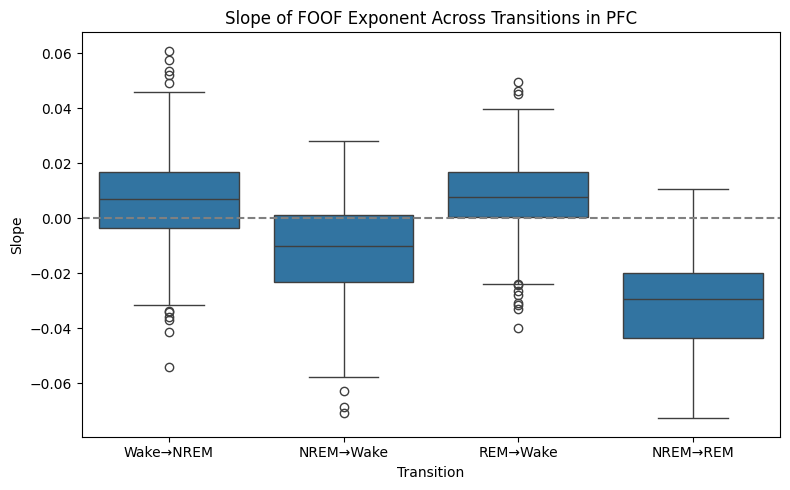

In [ ]:

REGION = "PFC"
hpc_slopes = collect_all_slopes(region=REGION)

df = analyze_slopes_welch_anova(hpc_slopes)

test_heterogeneity(df)

plt.figure(figsize=(8, 5))
sns.boxplot(x="Transition", y="Slope", data=df)
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"Slope of FOOF Exponent Across Transitions in {REGION}")
plt.tight_layout()
plt.show()

posthoc_results_pfc = pairwise_gameshowell(dv='Slope', between='Transition', data=df)


ANOVA result: F = 173.2490, p = 0.000000
Levene’s test for equal variances: W = 1.0681, p = 0.361384
→ No significant heterogeneity; variances are similar across groups.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


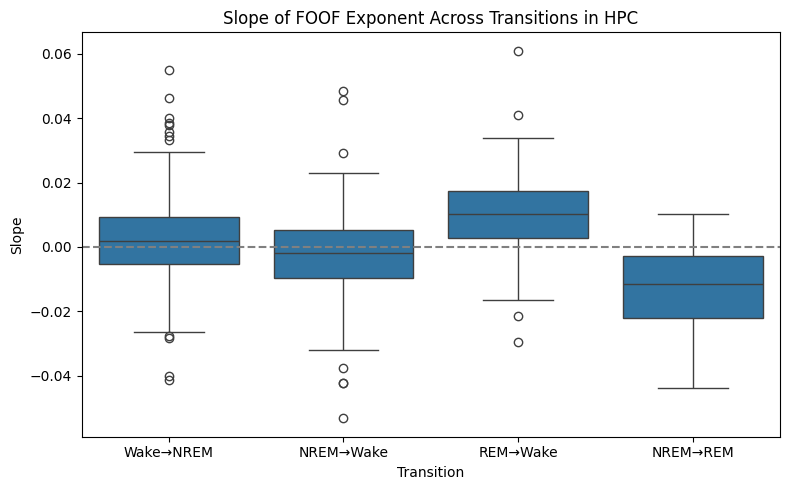

In [128]:
REGION = "HPC"
hpc_slopes = collect_all_slopes(region=REGION)

df = analyze_slopes_anova(hpc_slopes)

test_heterogeneity(df)
plt.figure(figsize=(8, 5))
sns.boxplot(x="Transition", y="Slope", data=df)
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"Slope of FOOF Exponent Across Transitions in {REGION}")
plt.tight_layout()
plt.show()

posthoc_results_hpc = pairwise_gameshowell(dv='Slope', between='Transition', data=df)


           A          B   mean(A)   mean(B)      diff        se          T  \
0   NREM→REM  NREM→Wake -0.012405 -0.002370 -0.010036  0.001059  -9.475815   
1   NREM→REM   REM→Wake -0.012405  0.010095 -0.022501  0.001154 -19.492283   
2   NREM→REM  Wake→NREM -0.012405  0.002017 -0.014422  0.001035 -13.932402   
3  NREM→Wake   REM→Wake -0.002370  0.010095 -0.012465  0.000718 -17.356444   
4  NREM→Wake  Wake→NREM -0.002370  0.002017 -0.004386  0.000505  -8.689407   
5   REM→Wake  Wake→NREM  0.010095  0.002017  0.008078  0.000682  11.838975   

            df          pval    hedges  
0   194.702063  1.654232e-14 -0.883992  
1   260.723153  9.547918e-15 -1.954263  
2   178.223106  0.000000e+00 -1.274980  
3   658.271579  1.225686e-13 -1.106512  
4  1773.032140  0.000000e+00 -0.390396  
5   563.846761  0.000000e+00  0.717990  


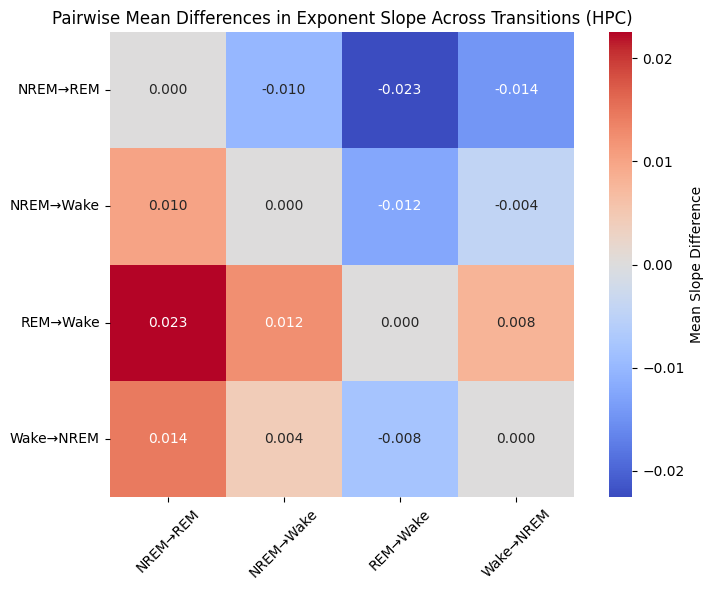

In [131]:


print(posthoc_results_hpc)


pivot = posthoc_results_hpc.pivot(index="A", columns="B", values="diff")


all_labels = sorted(set(pivot.index).union(set(pivot.columns)))
full_matrix = pd.DataFrame(index=all_labels, columns=all_labels, dtype=float)


for _, row in posthoc_results_hpc.iterrows():
    full_matrix.loc[row['A'], row['B']] = row['diff']
    full_matrix.loc[row['B'], row['A']] = -row['diff']  


np.fill_diagonal(full_matrix.values, 0)


plt.figure(figsize=(8, 6))
sns.heatmap(full_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0, square=True,
            cbar_kws={"label": "Mean Slope Difference"})
plt.title("Pairwise Mean Differences in Exponent Slope Across Transitions (HPC)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



       Source  ddof1       ddof2           F          p-unc       np2
0  Transition      3  558.209144  411.165532  6.873656e-141  0.339345
Levene’s test for equal variances: W = 10.9132, p = 0.000000
→ Variances are significantly different (heterogeneity present).


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


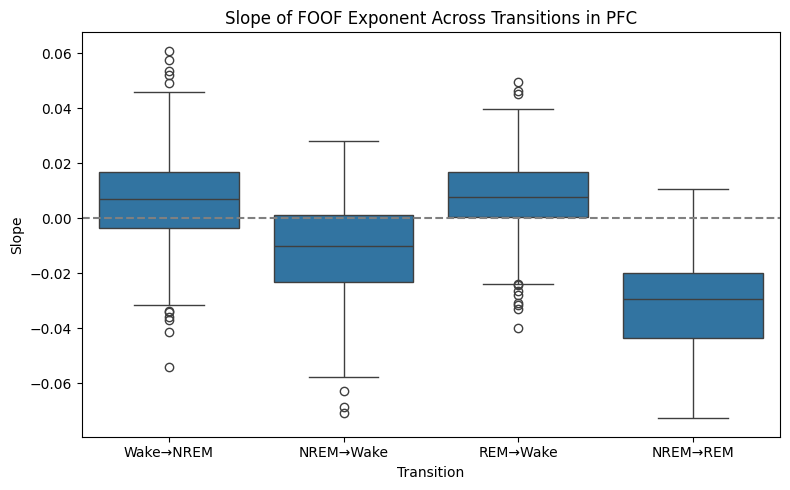

In [132]:

REGION = "PFC"
hpc_slopes = collect_all_slopes(region=REGION)

df = analyze_slopes_welch_anova(hpc_slopes)

test_heterogeneity(df)

plt.figure(figsize=(8, 5))
sns.boxplot(x="Transition", y="Slope", data=df)
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"Slope of FOOF Exponent Across Transitions in {REGION}")
plt.tight_layout()
plt.show()

posthoc_results_pfc = pairwise_gameshowell(dv='Slope', between='Transition', data=df)


           A          B   mean(A)   mean(B)      diff        se          T  \
0   NREM→REM  NREM→Wake -0.031291 -0.011418 -0.019873  0.001522 -13.054934   
1   NREM→REM   REM→Wake -0.031291  0.008070 -0.039361  0.001582 -24.874796   
2   NREM→REM  Wake→NREM -0.031291  0.007057 -0.038348  0.001465 -26.174714   
3  NREM→Wake   REM→Wake -0.011418  0.008070 -0.019488  0.000955 -20.401559   
4  NREM→Wake  Wake→NREM -0.011418  0.007057 -0.018475  0.000745 -24.798333   
5   REM→Wake  Wake→NREM  0.008070  0.007057  0.001013  0.000861   1.175947   

            df          pval    hedges  
0   204.016303  0.000000e+00 -1.149331  
1   232.041303  5.750955e-14 -2.641684  
2   175.917904  0.000000e+00 -2.464207  
3   818.500077  0.000000e+00 -1.188125  
4  1627.740298  8.402168e-13 -1.140459  
5   619.509521  6.422938e-01  0.067176  


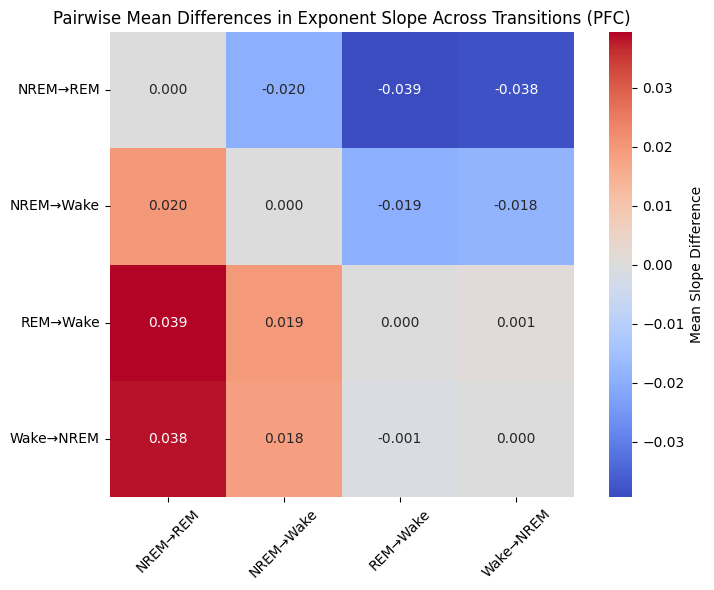

In [ ]:


print(posthoc_results_pfc)

pivot = posthoc_results_pfc.pivot(index="A", columns="B", values="diff")


all_labels = sorted(set(pivot.index).union(set(pivot.columns)))
full_matrix = pd.DataFrame(index=all_labels, columns=all_labels, dtype=float)


for _, row in posthoc_results_pfc.iterrows():
    full_matrix.loc[row['A'], row['B']] = row['diff']
    full_matrix.loc[row['B'], row['A']] = -row['diff'] 


np.fill_diagonal(full_matrix.values, 0)


plt.figure(figsize=(8, 6))
sns.heatmap(full_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0, square=True,
            cbar_kws={"label": "Mean Slope Difference"})
plt.title("Pairwise Mean Differences in Exponent Slope Across Transitions (PFC)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



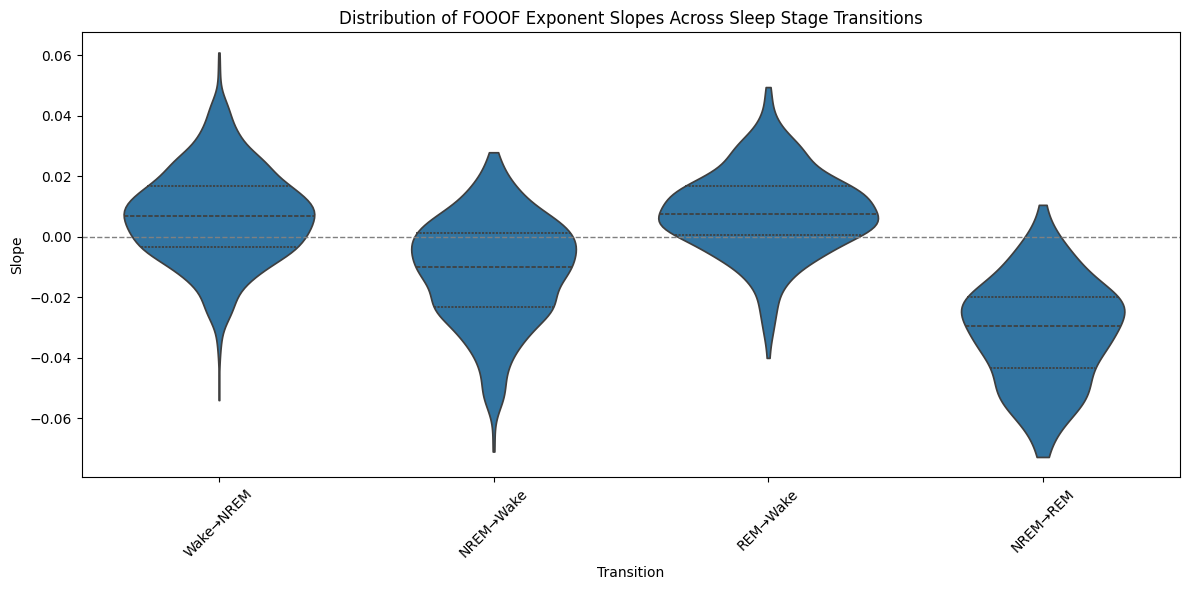

In [135]:


plt.figure(figsize=(12, 6))
sns.violinplot(x="Transition", y="Slope", data=df, inner="quartile", cut=0)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Distribution of FOOOF Exponent Slopes Across Sleep Stage Transitions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [136]:



STATE_MAP = {
    1: 'Wake',
    3: 'NREM',
    4: 'Inter',
    5: 'REM'
}

# Most common transitions in order
TRANSITIONS = [
    (1, 3),  # Wake → NREM
    (3, 1),  # NREM → Wake
    (5, 1),  # REM → Wake
    (3, 5),  # NREM → REM

]
CONTROL_RATS = [1, 2, 6, 9]
RGS_RATS = [3, 4, 7, 8]
ALL_RATS = CONTROL_RATS + RGS_RATS
MARGIN_SEC = 15
WINDOW_SEC = 15


def collect_transition_slopes(states, exponents, times, transitions, margin_sec=MARGIN_SEC, window_sec=WINDOW_SEC):
    step_sec = (window_sec * 1000 - window_sec * 1000 // 2) / 1000
    half_win = int(margin_sec / step_sec)
    state_bins = states[np.minimum(times.astype(int), len(states) - 1)]
    slopes = {tr: [] for tr in transitions}
    time_rel = np.arange(-margin_sec, margin_sec + step_sec, step_sec)

    for from_state, to_state in transitions:
        is_from = state_bins == from_state
        is_to = state_bins == to_state
        trans_idxs = np.where(is_to & np.roll(is_from, 1))[0]
        for idx in trans_idxs:
            start = idx - half_win
            end = idx + half_win + 1
            if start >= 0 and end <= len(exponents):
                win = exponents[start:end]
                if len(win) == len(time_rel) and not np.isnan(win).any():
                    slope, _ = np.polyfit(time_rel, win, 1)
                    slopes[(from_state, to_state)].append(slope)
    return slopes

def collect_all_slopes(base_dir="./data", foof_dir="./data/FoofExponents"):
    all_data = []
    
    for rat_id in ALL_RATS:
        rat_str = f"Rat{rat_id}"
        group = "HomeCage" if rat_id in CONTROL_RATS else "Learning"
        
        for condition in os.listdir(base_dir):
            for region in ['HPC', 'PFC']:
                rat_dir = os.path.join(base_dir, condition, rat_str, "Post-Trial5")
                states_file = os.path.join(rat_dir, "states.mat")
                foof_file = os.path.join(foof_dir, condition, f"FOOF_{rat_str}_{region}.npz")
                
                if not (os.path.exists(states_file) and os.path.exists(foof_file)):
                    continue
                    
                states = sio.loadmat(states_file)["states"].ravel()
                foof_data = np.load(foof_file)
                exponents = foof_data["exponents"]
                times = foof_data["times"]
                
                rat_slopes = collect_transition_slopes(states, exponents, times, TRANSITIONS)
                
                for tr in TRANSITIONS:
                    for slope in rat_slopes[tr]:
                        all_data.append({
                            'Slope': slope,
                            'Transition': f"{STATE_MAP[tr[0]]}→{STATE_MAP[tr[1]]}",
                            'Group': group,
                            'Region': region
                        })
    
    return pd.DataFrame(all_data)

def analyze_slopes_anova(df):
    anova_results = pg.anova(data=df, dv='Slope', between=['Group', 'Transition'], detailed=True)
    print("Two-way ANOVA results:")
    print(anova_results)
    
    # Post-hoc (Games-Howell) per transition
    print("\nPost-hoc analysis per transition:")
    for transition in df['Transition'].unique():
        subset = df[df['Transition'] == transition]
        posthoc = pg.pairwise_gameshowell(dv='Slope', between='Group', data=subset)
        print(f"\nPost-hoc for {transition}:")
        print(posthoc)
    
    return anova_results

def analyze_slopes_welch_anova(all_slopes):
    labels = []
    slopes_flat = []

    for tr in TRANSITIONS:
        label = f"{STATE_MAP[tr[0]]}→{STATE_MAP[tr[1]]}"
        labels.extend([label] * len(all_slopes[tr]))
        slopes_flat.extend(all_slopes[tr])

    df = pd.DataFrame({
        "Transition": labels,
        "Slope": slopes_flat
    })


    welch = pg.welch_anova(dv='Slope', between='Transition', data=df)
    print(welch)

    return df


def test_heterogeneity(df):
    groups = [df[df["Transition"] == label]["Slope"].values for label in df["Transition"].unique()]
    stat, p = levene(*groups)
    print(f"Levene’s test for equal variances: W = {stat:.4f}, p = {p:.6f}")
    if p < 0.05:
        print("→ Variances are significantly different (heterogeneity present).")
    else:
        print("→ No significant heterogeneity; variances are similar across groups.")


In [137]:
# Collect all the data
df = collect_all_slopes()

# Run the two-way ANOVA analysis
anova_results = analyze_slopes_anova(df)

Two-way ANOVA results:
               Source        SS      DF        MS           F          p-unc  \
0               Group  0.001199     1.0  0.001199    5.839347   1.570646e-02   
1          Transition  0.327303     3.0  0.109101  531.528235  1.201893e-300   
2  Group * Transition  0.001356     3.0  0.000452    2.202355   8.567103e-02   
3            Residual  1.048873  5110.0  0.000205         NaN            NaN   

        np2  
0  0.001141  
1  0.237835  
2  0.001291  
3       NaN  

Post-hoc analysis per transition:

Post-hoc for Wake→NREM:
          A         B   mean(A)  mean(B)      diff        se         T  \
0  HomeCage  Learning  0.004346  0.00469 -0.000343  0.000558 -0.615258   

            df      pval    hedges  
0  2304.486354  0.538445 -0.025057  

Post-hoc for NREM→Wake:
          A         B  mean(A)   mean(B)      diff        se         T  \
0  HomeCage  Learning -0.00726 -0.006593 -0.000667  0.000761 -0.876325   

            df     pval    hedges  
0  1539.37587